In [1]:
# !pip install transformers pandas torch

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [8]:
# Memuat dataset
# df = pd.read_csv('news_with_sentiment_and_company.csv')
df = pd.read_csv('combined_coba.csv')
df['content'].fillna('', inplace=True)

# Prepare IndoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

class IndoBERTRegressionModel(nn.Module):
    def __init__(self):
        super(IndoBERTRegressionModel, self).__init__()
        self.bert = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)  # Output layer untuk regresi

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Ambil [CLS] token
        regression_output = self.regressor(cls_output)
        return regression_output

# Dataset class untuk DataLoader
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.loc[index, 'content']
        sentiment = self.data.loc[index, 'predicted_sentiment']
        inputs = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].flatten()  # Flatten memastikan dimensi tetap konsisten
        attention_mask = inputs['attention_mask'].flatten()
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'predicted_sentiment': torch.tensor(sentiment, dtype=torch.float)}

In [12]:
# Parameters
max_length = 128
batch_size = 16
learning_rate = 2e-5
num_epochs = 3

# Dataset dan DataLoader
train_dataset = NewsDataset(df, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = IndoBERTRegressionModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Loss function untuk regresi

# Training loop
# model.train()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['predicted_sentiment'].to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        outputs = outputs.view(-1)  # Ubah menjadi array 1D
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss}")

Training Epoch 1:   0%|                                                                         | 0/19 [00:00<?, ?it/s]C:\Users\raraslab\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
C:\Users\raraslab\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training Epoch 1:  95%|████████████████████████████████████████████████████████████▋   | 18/19 [00:04<00:00,  4.28it/s]C:\Users\raraslab\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target si

Epoch 1 | Loss: 0.5836178619218501


Training Epoch 2: 100%|████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.37it/s]


Epoch 2 | Loss: 0.09293353636013835


Training Epoch 3: 100%|████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.34it/s]

Epoch 3 | Loss: 0.033996552719097385


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_values = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['predicted_sentiment'].to(device)

            # Get model predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            outputs = outputs.view(-1).cpu().numpy()  # Ensure outputs are 1D
            labels = labels.cpu().numpy()  # Convert labels to numpy array

            predictions.extend(outputs)
            true_values.extend(labels)

    # Calculate evaluation metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    rmse = sqrt(mse)  # Calculate RMSE

    print("Evaluation Results:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")
    return mse, mae, r2, rmse, true_values, predictions

# Prepare data for evaluation
eval_dataset = NewsDataset(df, tokenizer, max_length)  # Assuming using the same dataset for simplicity
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# Perform evaluation
mse, mae, r2, rmse, true_values, predictions = evaluate_model(model, eval_loader, device)

Evaluation Results:
Mean Squared Error (MSE): 0.018667422235012054
Root Mean Squared Error (RMSE): 0.13662877528182726
Mean Absolute Error (MAE): 0.11100219935178757
R-squared (R²): -1.200825529300214


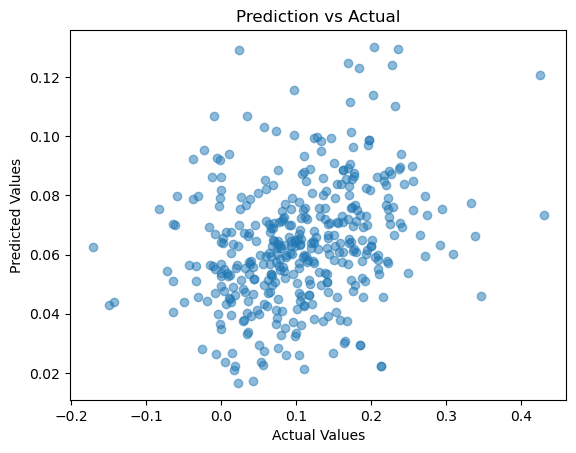

In [13]:
import matplotlib.pyplot as plt

# Plot prediksi vs nilai aktual
plt.scatter(true_values, predictions, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual")
plt.show()

In [15]:
import torch

# Simpan model IndoBERT
model.bert.save_pretrained("indobert_regression_model_bca")
tokenizer.save_pretrained("indobert_regression_model_bca")

# Simpan seluruh model kustom (model IndoBERT + regressor layer)
torch.save(model.state_dict(), "indobert_regression_model_bca/full_model.pth")

In [11]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Memuat dataset
# data = pd.read_csv('news_with_sentiment_and_company.csv')
# data['content'].fillna('', inplace=True)

# # Menampilkan beberapa baris pertama untuk memastikan data sudah benar
# print(data.head())

# # Bagi data menjadi train dan test set
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


                                               title  \
0  \nLangkah BCA Sukseskan Pariwisata Sebagai Cor...   
1  \nBCA dan Bank Mandiri Angkat Suara soal M-Ban...   
2  \nNetizen Teriak! M-Banking BCA dan Bank Mandi...   
3  \nBCA Borong 26 Penghargaan di Ajang Contact C...   
4  \nAksi Heroik Polisi Malang Gagalkan Mahasiswa...   

                               category        Date  \
0     \r\n           detikNews           2020-01-10   
1  \r\n           detikFinance           2020-01-30   
2  \r\n           detikFinance           2020-01-30   
3     \r\n           detikNews           2020-02-04   
4     \r\n           detikNews           2020-02-08   

                                             content  \
0  Sebanyak 25 pemandu wisata outbond Desa Pentin...   
1  Sejumlah nasabah pengguna layanan mobile banki...   
2  Sejumlah orang mengeluhkan adanya eror pada la...   
3  PT Bank Central Asia Tbk (BCA) melalui Halo BC...   
4  Peristiwa terjadi Jumat (7/2/2020) siang. Saat...

In [13]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch
# from torch.utils.data import Dataset, DataLoader
# from transformers import AdamW
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score, classification_report

# # Memuat tokenizer dan model IndoBERT
# tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
# model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# # Dataset
# class SentimentDataset(Dataset):
#     def __init__(self, data, tokenizer, max_length=128):
#         self.data = data
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         row = self.data.iloc[index]
#         text = row['content']
#         label = int(row['sentiment']) + 1  # [-1, 0, 1] -> [0, 1, 2]
        
#         inputs = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
#         inputs['labels'] = torch.tensor(label, dtype=torch.long)
#         return inputs

# # DataLoader
# train_dataloader = DataLoader(SentimentDataset(train_data, tokenizer), batch_size=8, shuffle=True)
# test_dataloader = DataLoader(SentimentDataset(test_data, tokenizer), batch_size=8)

In [17]:
# # Optimizer
# optimizer = AdamW(model.parameters(), lr=2e-5)

# # Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Training Loop
# epochs = 3
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
#         input_ids = batch['input_ids'].to(device).view(-1, batch['input_ids'].size(-1))
#         attention_mask = batch['attention_mask'].to(device).view(-1, batch['attention_mask'].size(-1))
#         labels = batch['labels'].to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Loss Epoch {epoch + 1}: {total_loss / len(train_dataloader)}")

C:\Users\raraslab\anaconda3\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1:   0%|                                                                         | 0/40 [00:00<?, ?it/s]C:\Users\raraslab\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training Epoch 1: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


Loss Epoch 1: 0.07425412120646797


Training Epoch 2: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]


Loss Epoch 2: 0.001831390190636739


Training Epoch 3: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.52it/s]


Loss Epoch 3: 0.0011929923173738643


In [21]:
# from sklearn.metrics import accuracy_score

# model.eval()
# predictions, true_labels = [], []

# with torch.no_grad():
#     for batch in tqdm(test_dataloader, desc="Evaluating"):
#         input_ids = batch['input_ids'].squeeze().to(device)
#         attention_mask = batch['attention_mask'].squeeze().to(device)
#         labels = batch['labels'].to(device)
        
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         logits = outputs.logits
#         predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
#         true_labels.extend(labels.cpu().numpy())

# # Menghitung akurasi
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Akurasi: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.19it/s]

Akurasi: 100.00%


In [23]:
# # Save model
# model.save_pretrained("indobert_sentiment_model_bca")
# tokenizer.save_pretrained("indobert_sentiment_model_bca")

('indobert_sentiment_model_bca\\tokenizer_config.json',
 'indobert_sentiment_model_bca\\special_tokens_map.json',
 'indobert_sentiment_model_bca\\vocab.txt',
 'indobert_sentiment_model_bca\\added_tokens.json',
 'indobert_sentiment_model_bca\\tokenizer.json')

### Prediksi

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import mse_loss
import numpy as np

# Pastikan perangkat GPU digunakan jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer dan model yang telah disimpan
tokenizer = AutoTokenizer.from_pretrained("indobert_regression_model")
loaded_bert = AutoModel.from_pretrained("indobert_regression_model")
# tokenizer = AutoTokenizer.from_pretrained("indobert_regression_model_bca")
# loaded_bert = AutoModel.from_pretrained("indobert_regression_model_bca")

# Load model kustom dan state_dict
class IndoBERTRegressionModel(torch.nn.Module):
    def __init__(self):
        super(IndoBERTRegressionModel, self).__init__()
        self.bert = loaded_bert
        self.regressor = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        sentiment_score = self.regressor(cls_output)
        return sentiment_score

# Inisialisasi model dan pindahkan ke perangkat yang digunakan
model = IndoBERTRegressionModel()
model.load_state_dict(torch.load("indobert_regression_model/full_model.pth"))
# model.load_state_dict(torch.load("indobert_regression_model_bca/full_model.pth"))
model.to(device)
model.eval()  # Set model ke mode evaluasi

IndoBERTRegressionModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [10]:
# Dataset untuk prediksi
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        content = self.df.loc[idx, 'content']
        inputs = self.tokenizer(
            content,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

# Load data baru untuk prediksi
# df_new = pd.read_csv("dataset_gabungan3.csv")
# df_new = pd.read_csv("sorted_articles_bca_fix.csv")
df_new = pd.read_csv("result_bank_bri_sorted.csv")
df_new['content'].fillna('', inplace=True)

# Siapkan DataLoader
new_dataset = NewsDataset(df_new, tokenizer, max_length=128)
new_loader = DataLoader(new_dataset, batch_size=8, shuffle=False)

# Fungsi untuk melakukan prediksi
# def predict_sentiment(model, data_loader, device):
#     model.eval()
#     predictions = []

#     with torch.no_grad():
#         for batch in data_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             outputs = outputs.squeeze().cpu().numpy()  # Mengubah hasil prediksi menjadi numpy array
#             predictions.extend(outputs)

#     return predictions

def predict_sentiment(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Mengubah tensor menjadi numpy array dan meresapkan hasil
            outputs = outputs.cpu().numpy()

            # Pastikan array menjadi 1 dimensi sebelum extend
            predictions.extend(outputs.flatten())  # Flatten akan menjaga prediksi tetap iterable

    return predictions

# Lakukan prediksi
predicted_sentiments = predict_sentiment(model, new_loader, device)

In [12]:
# Tambahkan hasil prediksi ke DataFrame dan simpan sebagai file baru
df_new['predicted_sentiment'] = predicted_sentiments
# df_new.to_csv("bca_news_with_predicted_sentiment3.csv", index=False)
df_new.to_csv("bri_news_with_predicted_sentiment2.csv", index=False)

print("Prediksi sentiment selesai. Hasil disimpan di 'news_with_predicted_sentiment.csv'")

Prediksi sentiment selesai. Hasil disimpan di 'news_with_predicted_sentiment.csv'


In [14]:
import pandas as pd

def average_sentiment_by_date(input_file, output_file):
    # Membaca file CSV yang sudah digabungkan
    df = pd.read_csv(input_file)

    # Mengonversi kolom 'Date' ke tipe datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Menghitung rata-rata skor sentimen untuk setiap tanggal
    # Pastikan kolom 'sentiment' ada dalam DataFrame
    average_df = df.groupby('Date', as_index=False)['predicted_sentiment'].mean()

    # Menyimpan hasil ke file CSV baru dengan hanya dua kolom: 'Date' dan 'Sentiment'
    average_df.columns = ['Date', 'Sentiment']  # Mengubah nama kolom
    average_df.to_csv(output_file, index=False)
    print(f"[~] Average sentiment by date saved to {output_file}")

# Contoh penggunaan
# average_sentiment_by_date("bca_news_with_predicted_sentiment2.csv", "bca_average_sentiment_by_date.csv")
average_sentiment_by_date("bri_news_with_predicted_sentiment2.csv", "mandiri_average_sentiment_by_date.csv")

[~] Average sentiment by date saved to mandiri_average_sentiment_by_date.csv
